# MEASURING STELLAR ELEMENTAL ABUNDANCES

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii
import pandas as pd
import astropy.constants as ac
import astropy.units as u

In [226]:
#give colab access to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## We will be looking at Sodium 5890 and 5896 doublet arises from the 3p - 3s transition.



## Import Solar Spectrum:

In [227]:
spec = astropy.io.ascii.read("/content/drive/My Drive/Colab Notebooks/solar_spectrum.txt")

In [228]:
specdf = pd.DataFrame(data=spec.as_array())

mins = specdf.loc[specdf['col2'] < 1000]

# Plot absorption line:

Text(0, 0.5, 'Normalized Flux')

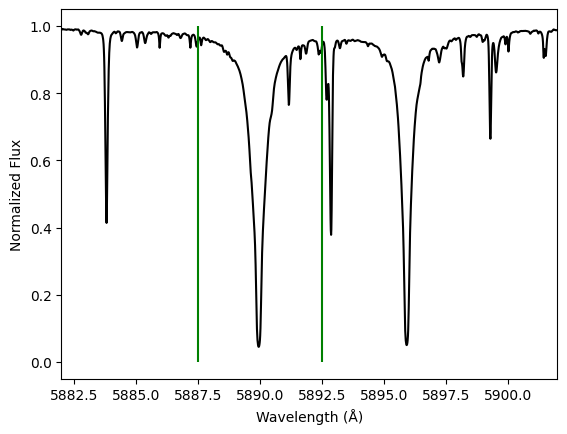

In [229]:
plt.plot(spec["col1"], spec["col2"] / 1e4, color="black")
plt.vlines(5887.5, 0, 1, color="green")
plt.vlines(5892.5, 0, 1, color="green")
plt.xlim(5882, 5902)
plt.xlabel("Wavelength (\u212B)")
plt.ylabel("Normalized Flux")

## Calculate equivalent width (EW), which is defined as: the width of a rectangle such that its area is equal to the area within the absorption line.

In [230]:
ind = np.where((spec["col1"] < 5892.5) & (spec["col1"] > 5887.5))
inc = np.median(np.diff(spec["col1"][ind]))
ew = np.sum(1e4 - spec["col2"][ind]) * inc / 1e4
print("equivalent width (ew) = ", ew, " Angstrom")

equivalent width (ew) =  0.8346720000182191  Angstrom


## Now find N using the curve of growth:

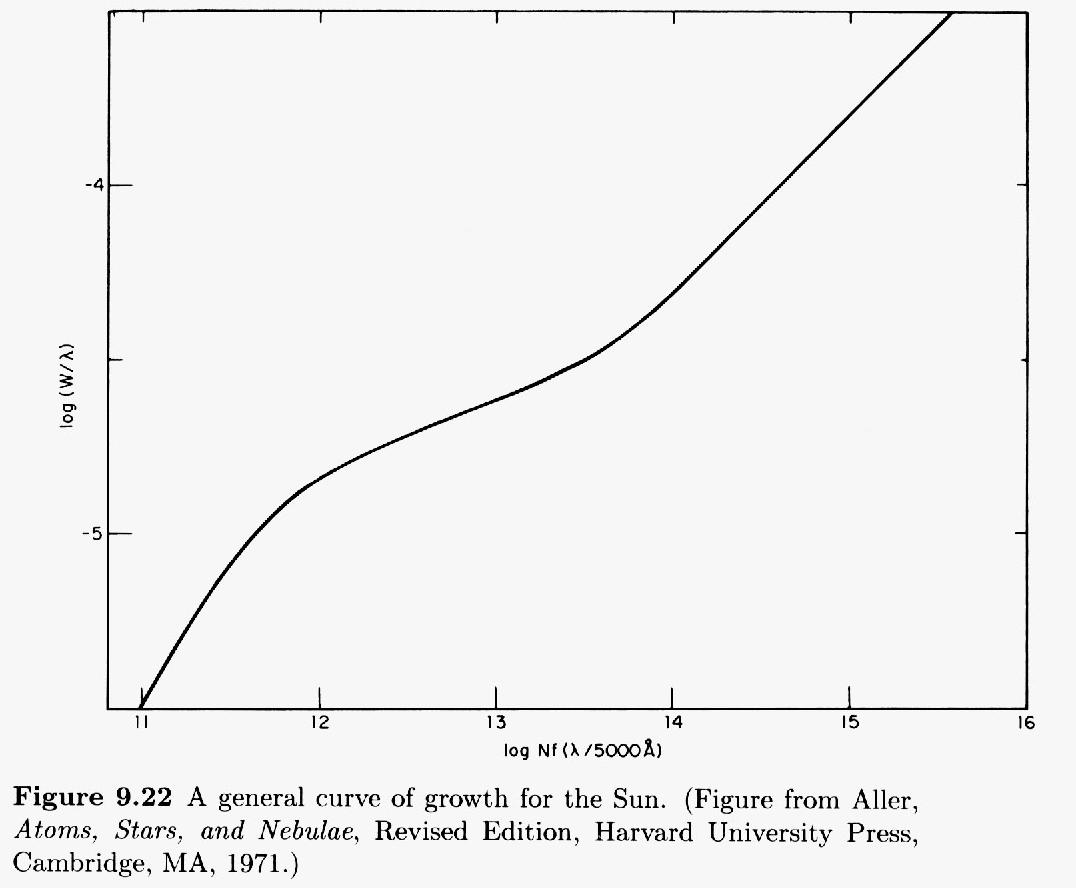

In [231]:
np.log10(0.83 / 5890.0)

np.float64(-3.8510372024110278)


## The corresponding value on x-axis is log(Nf($\lambda/5000$))$=$14.8.
## Assuming f = 0.65:

In [232]:
N1_sodium = (10**14.8 / 0.65 / (5890 / 5000) / 1e14) * (10**14)
print(N1_sodium)

824026830978443.6


## Questions:
## 1, Estimate the ratio of sodium atoms in the ground state to sodium atoms in excited states using the Boltzmann equation:

## $\frac{N_2}{N_1} = \frac{g_2}{g_1}e^\left({-\frac{E_2 - E_1}{kT}}\right)$, where subscripts 1 and 2 refer to 3s and 3p states, $N$ is number density, $g$ is the number of separate, individual states that are degenerate in energy, $E$ is energy at the state, $k$ is Boltzmann constant, and $T$ is temperature.

In [233]:
def boltzmann(g1, g2, Ediff, T):
  """
  Function will only work if energy is given in SI units

  """
  ratio = g2 / g1 * np.exp(-(Ediff) / (ac.k_B * T))
  return ratio

In [234]:
# Estimating ratio of sodium atoms
# Values

g1 = 2
g2 = 6
Ediff = 2.107 * (1.60218e-19) * u.Joule
T = 5772 * u.Kelvin # Kelvin

boltzmann_ratio = boltzmann(g1, g2, Ediff, T)
print(boltzmann_ratio)

0.04339165958005825


## 2, Estimate the ratio of neutral sodium atoms to ionized sodium atoms. You will use the Saha equation:

## $\frac{Na_{II}}{Na_{I}} = \frac{2kT}{P_e} \frac{Z_{II}}{Z_I} \left(\frac{2\pi m_e kT}{h^2}\right)^{3/2}e^{\left(-\frac{\chi}{kT}\right)}$, where $m_e$ is electron mass, partition function $Z_I = 2.4$ and  $Z_{II} = 1.0$, electron pressure $P_e = n_e kT = 1.0 N\cdot m^{-2}$, and the ionization energy $\chi = 5.1$ eV. Note that the values given are for the sodium line only. Other lines have different values.

In [235]:
def saha(z1, z2, chi, T, P_e):
  """
  Function only works if T is given in Kelvin (K)
  """
  a = 2 * ac.k_B * T / P_e
  b = z2 / z1 * (2 * np.pi * ac.m_e * ac.k_B * T / ac.h**2) ** (3/2)
  c = np.exp((-(chi * u.eV).to(u.Joule))  / (ac.k_B * T))

  ratio = a * b * c

  return ratio.decompose()

In [236]:
# Estimating ratio of neutral sodium atoms to ionized sodium atoms

P_e = (1.0 * u.N * u.m**(-2))
z1 = 2.4
z2 = 1.0
chi = 5.1 #ev

ion_ratio = saha(z1, z2, chi, T, P_e)
print(ion_ratio)

2477.7159196603775


## 3, Compute the total column density of sodium atoms in the sun's photosphere, assuming the total number of sodium atoms equals to: $N_{1} \times (1+\frac{N_2}{N_1}) \times (1+\frac{Na_{II}}{Na_{I}}$). $N_1$ is measured from the curve of growth. The last two terms have been calculated in question 1 and 2.

In [237]:
N1_sodium = (10**14.8 / 0.65 / (5890 / 5000) / 1e14) * (10**14)

def total_column_density(N1, boltzmann_ratio, ion_ratio):
  total_density = N1 * (1 + boltzmann_ratio) * (1 + ion_ratio)
  return total_density

density_sodium = total_column_density(N1_sodium, boltzmann_ratio, ion_ratio)
print(density_sodium)

2.1311571222378913e+18





## 4, The column density of hydrogen atoms is about $6.6\times10^{23}$; what is the abundance of sodium relative to hydrogen?

# This is what physicists use (the exact ratio).

In [238]:
density_hydrogen = 6.6 * 10**23
exact_abundance = density_sodium / density_hydrogen
print(exact_abundance)

3.2290259427846843e-06


# For astronomers working on galaxies: $12 + log_{10}(N_{element}/N_{H})$, where N is in mole or number density.

In [239]:
gal_relative_abundance = 12 + np.log10(density_sodium / density_hydrogen)
print(gal_relative_abundance)

6.509071534259333


# For astronomers working on stars they use the abundance relative to the Sun: $log_{10}(\frac{N_{element}/N_{H}}{(N_{element}/N_{H})_{\odot}})$

The official value from Palme et al. (2014) for the logarithmic abundance of Na is: $6.30$

=> $6.30 = 12 + log_{10}(N_{Na}/N_{H})$

=> $\frac{N_{Na}}{N_H} = 10^{(6.30 - 12)}$

In [240]:
sun_exact_abundance = 10**(6.30 - 12)
print(sun_exact_abundance)

1.9952623149688787e-06


In [241]:
sol_relative_abundance = np.log10((density_sodium / density_hydrogen)/(sun_exact_abundance))
print(sol_relative_abundance)

0.2090715342593338


# This is pretty close!

Now we attempt the same for Mg:

In [242]:
spec = np.loadtxt("/content/drive/My Drive/Colab Notebooks/Mg5168.txt")

Text(0, 0.5, 'Flux')

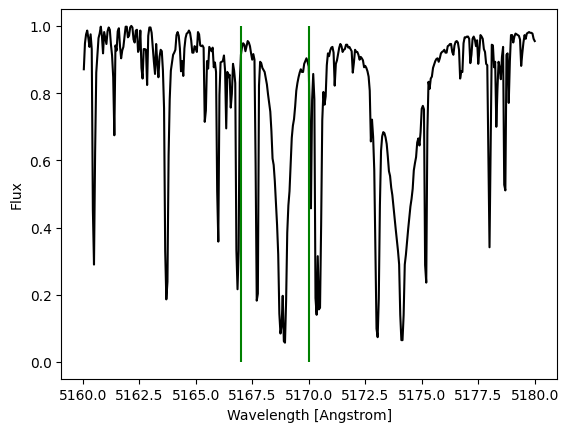

In [243]:
wav = spec[:,0]
flx = spec[:,1]
plt.plot(wav, flx, color="black")
plt.vlines(5167.0, 0, 1, color="green")
plt.vlines(5170.0, 0, 1, color="green")
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")

In [244]:
spec = astropy.io.ascii.read("/content/drive/My Drive/Colab Notebooks/Mg5168.txt")

In [245]:
ind = np.where((spec["col1"] < 5180.0) & (spec["col1"] > 5170.0))
inc = np.median(np.diff(spec["col1"][ind]))
ew = np.sum(1e4 - spec["col2"][ind]) * inc / 1e4
print("equivalent width (ew) = ", ew, " Angstrom")

equivalent width (ew) =  9.910373875288617  Angstrom


In [246]:
np.log10(ew / 5169.0)

np.float64(-2.7173164933320693)

In [247]:
10**14.8 / 0.117 / (5167 / 5000) / 1e14

52.18499918782694

$52.16\times10^{14}$ with the unit of atoms/cm$^2$, assuming f = 0.117, where f is the oscillator strength for this transition at 5167 $\overset{\circ}{A}$.

## 1, Estimate the ratio of mg atoms in the ground state to mg atoms in excited states using the Boltzmann equation:

## $\frac{N_2}{N_1} = \frac{g_2}{g_1}e^\left({-\frac{E_2 - E_1}{kT}}\right)$, where subscripts 1 and 2 refer to 3s and 3p states, $N$ is number density, $g$ is the number of separate, individual states that are degenerate in energy, $E$ is energy at the state, $k$ is Boltzmann constant, and $T$ is temperature.

In [248]:
# Estimating ratio of magnesium atoms
# Values

g1 = 2
g2 = 6
E3p = 12.08 #eV
E3s = 7.64 #eV
Ediff = (E3p - E3s) * (1.60218e-19) * u.Joule
T = 5772 * u.Kelvin # Kelvin

boltzmann_ratio = boltzmann(g1, g2, Ediff, T)
print(boltzmann_ratio)

0.000398437915941493


## 2, Estimate the ratio of neutral magnesium atoms to ionized magnesium atoms. You will use the Saha equation:

## $\frac{Mg_{II}}{Mg_{I}} = \frac{2kT}{P_e} \frac{Z_{II}}{Z_I} \left(\frac{2\pi m_e kT}{h^2}\right)^{3/2}e^{\left(-\frac{\chi}{kT}\right)}$, where $m_e$ is electron mass, partition function $Z_I = 1.0$ and  $Z_{II} = 1.0$, electron pressure $P_e = n_e kT = 0.001 N\cdot m^{-2}$, and the ionization energy $\chi = 7.6$ eV.




In [249]:
# Estimating ratio of neutral magnesium atoms to ionized magnesium atoms

P_e = (10**(-2) * u.N * u.m**(-2))
z1 = 1.0
z2 = 1.0
z3 = 1.0
chi = 7.6 #ev

ion_ratio = saha(z1, z2, chi, T, P_e)
print(ion_ratio)

3903.072726033447


## 3, Compute the total column density of mg atoms in the sun's photosphere, assuming the total number of mg atoms equals to: $N_{1} \times (1+\frac{N_2}{N_1}) \times (1+\frac{Mg_{II}}{Mg_{I}}$). $N_1$ is measured from the curve of growth. The last two terms have been calculated in question 1 and 2.

In [250]:
N1_mag = 10**14.8 / 0.117 / (5167 / 5000) / 1e14 * (10**14)

def total_column_density(N1, boltzmann_ratio, ion_ratio):
  total_density = N1 * (1 + boltzmann_ratio) * (1 + ion_ratio)
  return total_density

density_mag = total_column_density(N1_mag, boltzmann_ratio, ion_ratio)
print(density_mag)

2.03815207400404e+19


## 4, The column density of hydrogen atoms is about $6.6\times10^{23}$; what is the abundance of Mg relative to hydrogen?

# This is what physicists use (the exact ratio).

In [251]:
density_hydrogen = 6.6 * 10**23
exact_abundance = density_mag / density_hydrogen
print(exact_abundance)

3.088109203036425e-05


# For astronomers working on galaxies: $12 + log_{10}(N_{element}/N_{H})$, where N is in mole or number density.

In [252]:
gal_relative_abundance = 12 + np.log10(density_mag / density_hydrogen)
print(gal_relative_abundance)

7.489692649642183


# For astronomers working on stars they use the abundance relative to the Sun: $log_{10}(\frac{N_{element}/N_{H}}{(N_{element}/N_{H})_{\odot}})$

The official value from Palme et al. (2014) for the logarithmic abundance of Na is: $7.54$

=> $7.54 = 12 + log_{10}(N_{Na}/N_{H})$

=> $\frac{N_{Na}}{N_H} = 10^{(7.54 - 12)}$

In [253]:
sun_exact_abundance = 10**(7.54 - 12)
print(sun_exact_abundance)

3.467368504525317e-05


In [254]:
sol_relative_abundance = np.log10((density_mag / density_hydrogen)/(sun_exact_abundance))
print(sol_relative_abundance)

-0.05030735035781622


# Note: We found values here for Magnesium, but were not confident enough in our choices for the parameters and how to calculate them to include them in our paper. We leave the Magnesium results above anyway.